# Evaluation des prédictions

Cette partie s'attaque au problème de l'évaluation de la performance de prédiction.
Input : prediction binaire de l'activité + ground truth (données labellisées)
Output : analyse de la prédiction

<br>

Cette partie peut être réutilisée en standalone pour mesurer l'efficacité d'un algo de prédiction sur des times series binaires.

<br>
Etapes

1. Générer input data / récupérer prédiction du premier jet de l'AE/ utiliser la dataframe de test comme output AE
2. Récupérer test data avec labels

- Définir les seuils 0 à 100%

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Import functions from module.py ---
import sys
sys.path.insert(0,'..')
from module import plot_confusion_matrix, plot_activity_hist, load_dataset, detect_stages, eval, load_aggregate_dataset, time_in_range, segmentDf, create_sequence, train_test_split_dataset, convertToSequenceParameters

# Import des données 
- Fichier des predictions
- Fichier des donnees labellisées (considéré ground truth)

In [3]:
relpath = r"data_prediction.pkl"
pred = pd.read_pickle(relpath)

pred.head()

,Timestamp,list_idx_sequence_no_activity,list_idx_sequence_activity,nb_no_activity,nb_activity,total,method_prediction_1
0,2016-04-25 08:48:00,[0],[],1,0,1,0
1,2016-04-25 08:49:30,[0],[],1,0,1,0
2,2016-04-25 08:51:00,[0],[],1,0,1,0
3,2016-04-25 08:52:30,[0],[],1,0,1,0
4,2016-04-25 08:54:00,[0],[],1,0,1,0


In [4]:
# get resample period
resample_period = pred["Timestamp"][1] - pred["Timestamp"][0]

In [5]:
# get ground truth
df_gt = load_dataset("house1_power_blk2_labels.zip")
print("Longueur de la dataframe df_gt ground-truth au chargement", len(df_gt))
df_gt = df_gt[(df_gt.index>=pred["Timestamp"].min())&(df_gt.index<=pred["Timestamp"].max())]
print("Longueur de la dataframe df_gt ground-truth après restriction à la période de test", len(df_gt))
df_gt.head()

Longueur de la dataframe df_gt ground-truth au chargement 5439600
Longueur de la dataframe df_gt ground-truth après restriction à la période de test 1087111


,mains,activity,hour
datetime,,,
2016-04-25 08:48:00,732.0,0,8.8
2016-04-25 08:48:01,756.0,0,8.8
2016-04-25 08:48:02,752.0,0,8.8
2016-04-25 08:48:03,774.0,0,8.8
2016-04-25 08:48:04,749.0,0,8.8


# Visualisation des activités prédites et ground_truth

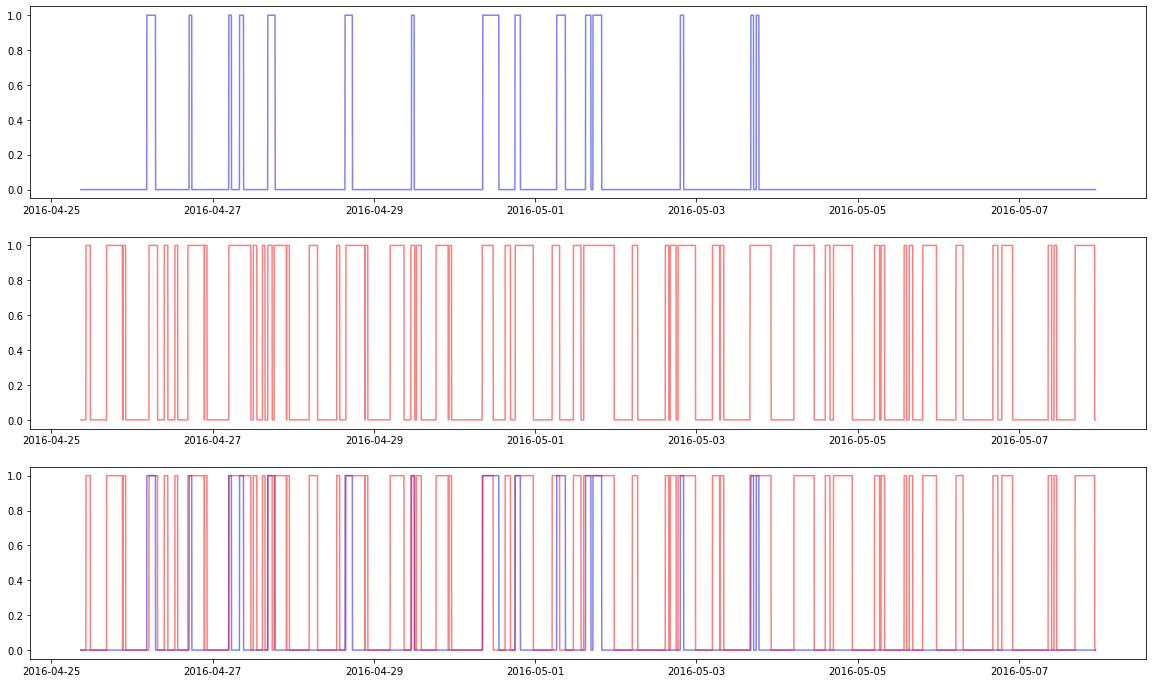

In [10]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches((20,12))
ax[0].plot(pred["Timestamp"], pred["method_prediction_1"], color = "blue", alpha = 0.5)
ax[1].plot(df_gt["activity"], color = "red", alpha = 0.5)
ax[2].plot(pred["Timestamp"], pred["method_prediction_1"], color = "blue", alpha = 0.5)
ax[2].plot(df_gt["activity"], color = "red", alpha = 0.5)

# ax[0].plot(df_gt["Timestamp"], pred["method_prediction_1"])

Ci dessous : passage au format de dataframe période

In [11]:
df_gt_period = detect_stages(df_gt, "activity", "datetime")
df_gt_period.head()

,activity,datetime_min,datetime_max,duration_min,duration_sec
stage,,,,,
0,0,2016-04-25 08:48:00,2016-04-25 10:16:41,88.0,5321.0
1,1,2016-04-25 10:16:42,2016-04-25 11:34:55,78.0,4693.0
2,0,2016-04-25 11:34:56,2016-04-25 16:24:59,290.0,17403.0
3,1,2016-04-25 16:25:00,2016-04-25 21:07:59,282.0,16979.0
4,0,2016-04-25 21:08:00,2016-04-25 21:21:08,13.0,788.0


In [12]:
pred_period = detect_stages(pred, "method_prediction_1", "Timestamp")
pred_period.head()

,method_prediction_1,Timestamp_min,Timestamp_max,duration_min,duration_sec
stage,,,,,
0,0,2016-04-25 08:48:00,2016-04-26 04:22:30,1174.0,70470.0
1,1,2016-04-26 04:24:00,2016-04-26 06:58:30,154.0,9270.0
2,0,2016-04-26 07:00:00,2016-04-26 16:58:30,598.0,35910.0
3,1,2016-04-26 17:00:00,2016-04-26 17:46:30,46.0,2790.0
4,0,2016-04-26 17:48:00,2016-04-27 04:46:30,658.0,39510.0


In [13]:
# get dataframe datetime pred gt : fusionner pred et df_gt

def get_TPTNFPFN(df_merged, col_pred, col_gt="activity"):
    """
    Computes TP, TN FP FN for an input dataframe with prediction and ground_truth columns 
    Args :
        -
    Return :
        - 
    """
    df = df_merged.copy()
    df["TP"] = np.where((df[col_pred]==1)&(df[col_gt]==1), 1, 0)
    df["TN"] = np.where((df[col_pred]==0)&(df[col_gt]==0), 1, 0)
    df["FP"] = np.where((df[col_pred]==1)&(df[col_gt]==0), 1, 0)
    df["FN"] = np.where((df[col_pred]==0)&(df[col_gt]==1), 1, 0)

    return df

df_merged = pred.set_index("Timestamp").join(df_gt, how='outer').fillna(method="ffill")
df_merged.head()
df_merged = get_TPTNFPFN(df_merged, col_pred="method_prediction_1", col_gt="activity")#.loc[:, ["TP"	,"TN",	"FP",	"FN"]]
# df_merged = get_TPTNFPFN(df_merged, col_pred="method_prediction_1", col_gt="activity").loc[:, ["TP"	,"TN",	"FP",	"FN"]]
df_merged = df_merged.reset_index().rename(columns={"index":'datetime'})
df_merged.head()

,datetime,list_idx_sequence_no_activity,list_idx_sequence_activity,nb_no_activity,nb_activity,total,method_prediction_1,mains,activity,hour,TP,TN,FP,FN
0,2016-04-25 08:48:00,[0],[],1,0,1,0.0,732.0,0,8.8,0,1,0,0
1,2016-04-25 08:48:01,[0],[],1,0,1,0.0,756.0,0,8.8,0,1,0,0
2,2016-04-25 08:48:02,[0],[],1,0,1,0.0,752.0,0,8.8,0,1,0,0
3,2016-04-25 08:48:03,[0],[],1,0,1,0.0,774.0,0,8.8,0,1,0,0
4,2016-04-25 08:48:04,[0],[],1,0,1,0.0,749.0,0,8.8,0,1,0,0


Text(0.5, 1.0, 'Pred vs ground_truth - brut instantané')

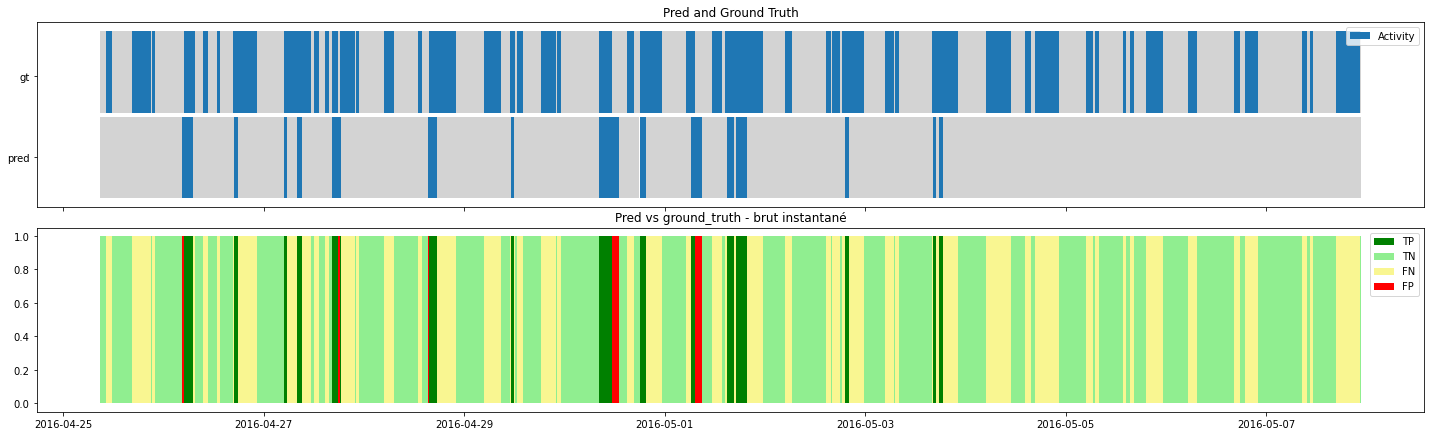

In [14]:
def broken_barh_x(df, col_bin, col_ts_min, col_ts_max):
    s1 = df.loc[df[col_bin]==1, col_ts_min]
    s0 = df.loc[df[col_bin]==0, col_ts_min]

    s1_length = df.loc[df[col_bin]==1, col_ts_max] - df.loc[df[col_bin]==1, col_ts_min]
    s0_length = df.loc[df[col_bin]==0, col_ts_max] - df.loc[df[col_bin]==0, col_ts_min]

    times1 = list(zip(s1,s1_length))
    times0 = list(zip(s0,s0_length))
    
    return times1, times0


fig, ax = plt.subplots(2, 1, sharex=True)
fig.set_size_inches((20,6))
plt.tight_layout()

# Plot 0
times1_pred, times0_pred = broken_barh_x(pred_period, "method_prediction_1", "Timestamp_min", "Timestamp_max")
ax[0].broken_barh(times1_pred, (0,1), label = "Activity")
ax[0].broken_barh(times0_pred, (0,1), facecolors='lightgray')

times1_gt, times0_gt = broken_barh_x(df_gt_period, "activity", "datetime_min", "datetime_max")
ax[0].broken_barh(times1_gt, (1.05,1))
ax[0].broken_barh(times0_gt, (1.05,1), facecolors='lightgray')

ax[0].set_yticks([0.5, 1.5], labels=['pred', 'gt'])
ax[0].legend()
ax[0].set_title("Pred and Ground Truth")

# Plot 1
for case, color in zip(["TP", "TN", "FN","FP"], ["green", "lightgreen", "#F9F691","red"]):
    df_tp = detect_stages(df_merged, case, "datetime")
    times, _ = broken_barh_x(df_tp, case, "datetime_min", "datetime_max")
    ax[1].broken_barh(times, (0,1), label = case, facecolors=color)

ax[1].legend()
ax[1].set_title("Pred vs ground_truth - brut instantané")

Cette première visualisation donne une indication de la performance mais n'est pas à prendre telle quelle car elle prend le temps comme un continuum, or on peut se permettre d'avoir un peu de battement sur la détection d'activité. Cette visualisation est donc plus "sévère" que ce que l'on souhaite réellement faire.

# Métriques

**Métrique 1 : IoU curves**
- mAP (mean average precision) or TP/FP ratio : a prediction activity period is considered a TP at a given threshold $\tau$ if :
    - the activity prediction period intersects a ground truth activity period or multiple ground_truth activity periods
    - the IoU $\frac{area_{pred}}{area_{ground truth}} > \tau $
- FN : starting from ground truth activity periods, FN happen when
    - a gt period does not meet a prediction period :
    - the IoU between 

Pour cette première métrique, on pretera une attention particulière au **taux de FP**, que l'on veut garder le plus bas possible, à un taux de **recall** donné. Notre objectif peut se traduire ainsi : "on souhaite détecter au moins 50 % des périodes d'activité réelles et à ce niveau minimiser les faux positifs pour éviter de dire qu'il y a eu de l'activité de manière erronnée". On pourra comprendre cette logique en imaginant le cas où quelqu'un est inconscient.

In [15]:
def get_IoU(df_period, col_period_min, col_period_max, ts_min, ts_max, col_bin,  activity):
    """
    Computes IoU between the period [ts_min, ts_max] and the corresponding periods of df_gt for activity/inactivity specified by activity 
    Args :
        -
    Return :
        - 
    """
    df = df_period[(df_period[col_period_max]>=ts_min)&(df_period[col_period_min]<=ts_max)].copy()
    df=df.loc[df[col_bin]==activity, :]
    
    # Compute Intersection I
    df["datetime_min_cut"] = ts_min
    df["datetime_min_cut"] = np.maximum(df[col_period_min], df["datetime_min_cut"])
    df["datetime_max_cut"] = ts_max
    df["datetime_max_cut"] = np.minimum(df[col_period_max], df["datetime_max_cut"])
    I = np.sum(df["datetime_max_cut"] - df["datetime_min_cut"]).seconds
    
    
    # Compute Union U
    U = np.sum(df["duration_sec"]) + (ts_max-ts_min).seconds - I # nécessité d'avoir une colonne "duration_sec" dans les dataframes utilisées

    IoU = I/U

    return df, U, I, IoU

def get_activity_stages(pred_period, col_method):
    return pred_period[pred_period[col_method]==1].copy()


In [16]:
# restriction aux périodes ground_truth d'activité
df_gt_period_activity = get_activity_stages(df_gt_period, "activity")

# restriction aux périodes prédites d'activité
pred_period_activity = get_activity_stages(pred_period, "method_prediction_1")
pred_period_activity.head()

,method_prediction_1,Timestamp_min,Timestamp_max,duration_min,duration_sec
stage,,,,,
1,1,2016-04-26 04:24:00,2016-04-26 06:58:30,154.0,9270.0
3,1,2016-04-26 17:00:00,2016-04-26 17:46:30,46.0,2790.0
5,1,2016-04-27 04:48:00,2016-04-27 05:34:30,46.0,2790.0
7,1,2016-04-27 08:00:00,2016-04-27 09:10:30,70.0,4230.0
9,1,2016-04-27 16:24:00,2016-04-27 18:34:30,130.0,7830.0


In [17]:
# ajout de la colonne de metrique IoU à la dataframe des predictions
l = []
for ts_min, ts_max in zip(pred_period_activity["Timestamp_min"], pred_period_activity["Timestamp_max"]):
    # l.append((get_IoU(df_gt_period, ts_min, ts_max, 1)[3]))
    l.append((get_IoU(df_gt_period, "datetime_min", "datetime_max", ts_min, ts_max, "activity",  activity=1))[3])
pred_period_activity["IoU"] = np.array(l)
# pred_period_activity.head()


# ajout de la colonne de metrique IoU à la dataframe ground_truth
l = []
for ts_min, ts_max in zip(df_gt_period_activity["datetime_min"], df_gt_period_activity["datetime_max"]):
    l.append((get_IoU(pred_period,"Timestamp_min", "Timestamp_max", ts_min, ts_max,"method_prediction_1" , 1)[3]))
df_gt_period_activity["IoU"] = np.array(l)
df_gt_period_activity.head()

,activity,datetime_min,datetime_max,duration_min,duration_sec,IoU
stage,,,,,,
1,1,2016-04-25 10:16:42,2016-04-25 11:34:55,78.0,4693.0,0.000000
3,1,2016-04-25 16:25:00,2016-04-25 21:07:59,282.0,16979.0,0.000000
5,1,2016-04-25 21:21:09,2016-04-25 22:06:19,45.0,2710.0,0.000000
7,1,2016-04-26 05:01:54,2016-04-26 07:35:01,153.0,9187.0,0.610418
9,1,2016-04-26 09:35:54,2016-04-26 10:39:10,63.0,3796.0,0.000000


Text(0.5, 33.0, 'IoU threshold tau (%)')

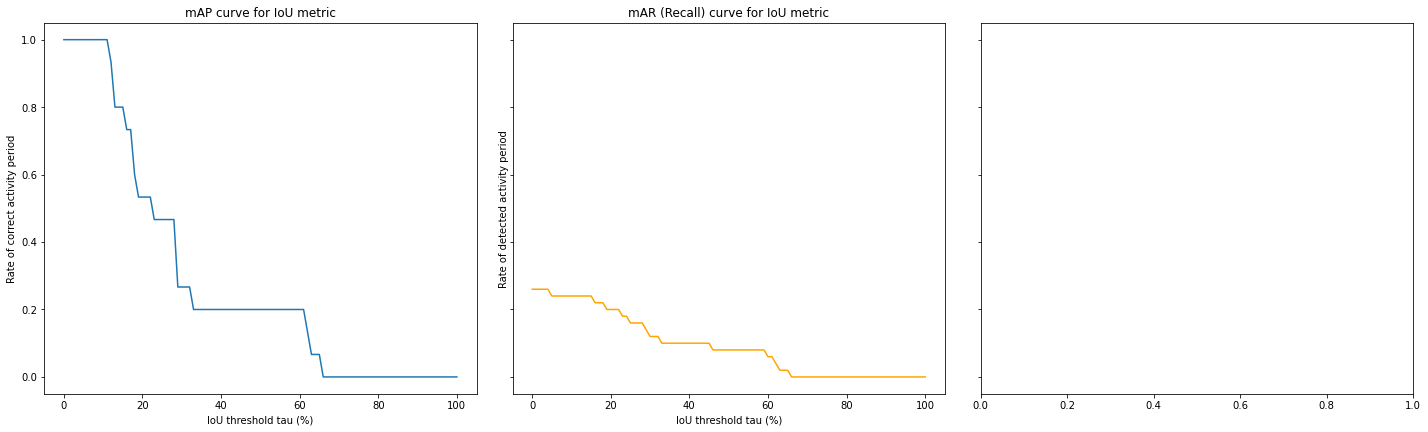

In [18]:
# Plot resultats

fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches((20,6))
plt.tight_layout(pad = 2.0)

tau_range = np.linspace(0,1,101)

N = len(pred_period_activity)
l = []
for tau in tau_range:
    l.append(len(pred_period_activity[pred_period_activity["IoU"]>tau])/N)
ax[0].plot(l)
ax[0].set_title("mAP curve for IoU metric")
ax[0].set_ylabel("Rate of correct activity period")
ax[0].set_xlabel("IoU threshold tau (%)")

N = len(df_gt_period_activity)
l = []
for tau in tau_range:
    l.append(len(df_gt_period_activity[df_gt_period_activity["IoU"]>tau])/N)
ax[1].plot(l, c='orange')
ax[1].set_title("mAR (Recall) curve for IoU metric")
ax[1].set_ylabel("Rate of detected activity period")
ax[1].set_xlabel("IoU threshold tau (%)")

# TODO : sorte de ROC curve pour combiner le recall et la precision

# <> Dev

In [127]:
def eval(pred, df_gt, display_plots=True):
    """
    Evaluer les prédictions en terme de mAP (mean avergae precision) et mAR (mean average recall)
    Args :
        - pred : dataframe de 2 colonnes : (timestamp, activity_prediction)
        - gt : dataframe de 2 colonnes : (timestamp, true_activity)
        - plot_recap : wether or not to display the summary of predicted and true activity
        - plot_metrics : wether or not to display the metrics plots
    Returns :
        - list of (IoU threshold, mAP, mAR)
        (- side effect : plots)
    """

    # resample_period = pred.iloc[1,0] - pred.iloc[0,0] # non utilisé
    
    colActivity_df_gt = df_gt.columns[1]
    colActivity_pred = pred.columns[1]

    df_gt_period = detect_stages(df_gt, colActivity_df_gt, df_gt.columns[0])
    pred_period = detect_stages(pred, colActivity_pred, pred.columns[0])
    
    df_merged = pred.set_index(pred.columns[0]).join(df_gt.set_index(df_gt.columns[0]), how='outer').fillna(method="ffill")
    df_merged = get_TPTNFPFN(df_merged, col_pred=colActivity_pred, col_gt=colActivity_df_gt)#.loc[:, ["TP"	,"TN",	"FP",	"FN"]]
    df_merged = df_merged.reset_index().rename(columns={"index":'datetime'})

    # restriction aux périodes ground_truth d'activité
    df_gt_period_activity = get_activity_stages(df_gt_period, colActivity_df_gt)
    # restriction aux périodes prédites d'activité
    pred_period_activity = get_activity_stages(pred_period, colActivity_pred)
    
    # # ajout de la colonne de metrique IoU à la dataframe des predictions
    l = []
    for ts_min, ts_max in zip(pred_period_activity.iloc[:,1], pred_period_activity.iloc[:,2]): # col 1 for timestamp min, col 2 for timestamp max
        l.append((get_IoU(df_gt_period, df_gt_period.columns[1], df_gt_period.columns[2]
                            , ts_min, ts_max, colActivity_df_gt,  activity=1))[3])
    pred_period_activity["IoU"] = np.array(l)

     # ajout de la colonne de metrique IoU à la dataframe ground_truth
    l = []
    for ts_min, ts_max in zip(df_gt_period_activity.iloc[:,1], df_gt_period_activity.iloc[:,2]):
        l.append((get_IoU(pred_period,pred_period.columns[1], pred_period.columns[2]
                        , ts_min, ts_max, colActivity_pred, 1)[3]))
    df_gt_period_activity["IoU"] = np.array(l)
    df_gt_period_activity.head()

    
    # === Calcul des métriques ===

    tau_range = np.linspace(0,1,101)
    
    # calcul du mAP
    N = len(pred_period_activity)
    map = []
    for tau in tau_range:
        map.append(len(pred_period_activity[pred_period_activity["IoU"]>tau])/N)

    # calcul du mAR
    N = len(df_gt_period_activity)
    mar = []
    for tau in tau_range:
        mar.append(len(df_gt_period_activity[df_gt_period_activity["IoU"]>tau])/N)


     #=================== = Plots = ====================

    if display_plots:
        fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [4, 1]})
        fig.set_size_inches(20, 6)
    
    
    # Plot summary 0
    col_timestamp_min_pred_period = pred_period.columns[1]
    col_timestamp_max_pred_period = pred_period.columns[2]
    times1_pred, times0_pred = broken_barh_x(pred_period, colActivity_pred, col_timestamp_min_pred_period, col_timestamp_max_pred_period)
    ax[0,0].broken_barh(times1_pred, (0,1), label = "Activity")
    ax[0,0].broken_barh(times0_pred, (0,1), facecolors='lightgray')

    col_timestamp_min_dfgt_period = df_gt_period.columns[1]
    col_timestamp_max_dfgt_period = df_gt_period.columns[2]
    times1_gt, times0_gt = broken_barh_x(df_gt_period, colActivity_df_gt, col_timestamp_min_dfgt_period, col_timestamp_max_dfgt_period)
    ax[0,0].broken_barh(times1_gt, (1.05,1))
    ax[0,0].broken_barh(times0_gt, (1.05,1), facecolors='lightgray')

    ax[0,0].set_yticks([0.5, 1.5], labels=['pred', 'gt'])
    ax[0,0].legend()
    ax[0,0].set_title("Pred and Ground Truth")

    # Plot summary 1
    for case, color in zip(["TP", "TN", "FN","FP"], ["green", "lightgreen", "#F9F691","red"]):
        df_tp = detect_stages(df_merged, case, df_merged.columns[0])
        times, _ = broken_barh_x(df_tp, case, df_tp.columns[1], df_tp.columns[2])
        ax[1,0].broken_barh(times, (0,1), label = case, facecolors=color)

    ax[1,0].legend()
    ax[1,0].set_title("Pred vs ground_truth - brut instantané")
    plt.tight_layout()

    # Plot curves
    ax[0,1].plot(map, label = "mAP : rate of correct activity period")
    ax[0,1].plot(mar, c='orange', label="mAR : rate of detected activity period")
    ax[0,1].set_title("mAP and mAR curves for IoU metric")
    ax[0,1].set_ylabel("Rate")
    ax[0,1].set_xlabel("IoU threshold tau (%)")
    ax[0,1].legend()
    
    return (tau_range, map, mar)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9333333333333333,
  0.8,
  0.8,
  0.8,
  0.7333333333333333,
  0.7333333333333333,
  0.6,
  0.5333333333333333,
  0.5333333333333333,
  0.5333333333333333,
  0.5333333333333333,
  0.4666666666666667,
  0.4666666666666667,
  

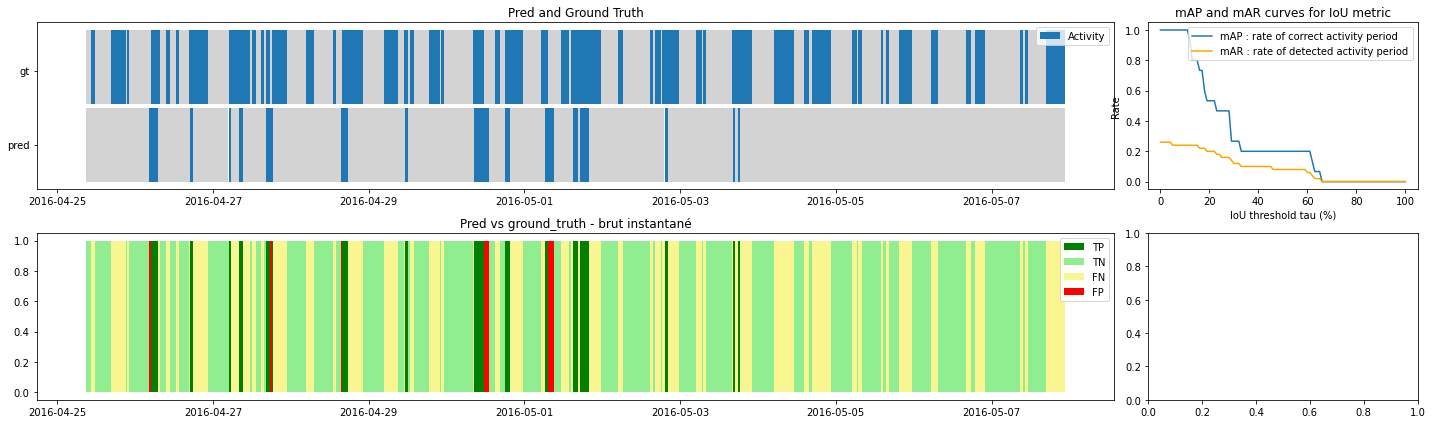

In [8]:
eval(pred[["Timestamp", "method_prediction_1"]], df_gt.reset_index()[["datetime", "activity"]], display_plots=True)

# Degub

# A faire
- Solidifier le format des predictions
    - preciser le fichier d'origine (house1/house2)
    - donner une description des colonnes transmises et métadonnées : resample period utilisée et autres infos qui pourraient être utiles



# Idées
- Donner encore plus de battement aux périodes prédites en autorisant pas de contact (threshold négatif)
- Interprétation : regarder les cas où la prédiction est correcte/erronée pour améliorer le modèle
- Répercuter les métriques dans l'AE pour pouvoir les suivres pendant l'entraînement

In [23]:
%matplotlib inline
from IPython.display import Image
Image(r"C:\Users\leroy\OneDrive\Bureau\K\2_MS_TelecomParis\Cours\Projet_Fil_Rouge\Activity_Detection_From_Electrical_Consumption_Load_Curves\Images\EvaluationMetric\evaluation_metric_periodes_predites_proches.png")

FileNotFoundError: No such file or directory: 'C:\Users\leroy\OneDrive\Bureau\K\2_MS_TelecomParis\Cours\Projet_Fil_Rouge\Activity_Detection_From_Electrical_Consumption_Load_Curves\Images\EvaluationMetric\evaluation_metric_periodes_predites_proches.png'

FileNotFoundError: No such file or directory: 'C:\Users\leroy\OneDrive\Bureau\K\2_MS_TelecomParis\Cours\Projet_Fil_Rouge\Activity_Detection_From_Electrical_Consumption_Load_Curves\Images\EvaluationMetric\evaluation_metric_periodes_predites_proches.png'

<IPython.core.display.Image object>